In [ ]:
#Арсенюк Александр, Галиев Руслан, Даминов Ильназ, Павличенков Игорь

In [1]:
# Цель работы -  построить поведенческую модель 
# покупателей для прогнозирования вероятности и ожидаемого времени отмены заказа.
# Необходимо решить задачу прогнозирования вероятности отказа клиента 
# от заказа без учета времени и стадии формирования заказа. 
# В качестве исходных данных для построения модели предоставляется подвыборка (sample) 
# истории заказов клиентов за определенный период времени с бинарной целевой переменной – 
# признаком того, что заказ был отменен клиентом. 
# Набор данных разбит на тренировочный (до 1 _января_ 2019 года) и тестовый (до 1 августа 2019 года).
# В тестовом наборе целевая переменная скрыта от участников и задачей является предсказание вероятности отказа.

In [2]:
# Что имеем: 9 миллионов строк и 14 колонок
# Date - Плановая дата доставки до клиента
# DateOrder - Дата оформления заказа
# ClientID - ID клиента
# ChannelID - канал сбыта
# OrderID - Номер заказа, присваевымый сайтом
# MaterialID - ID материала
# GroupID - Группа Закупок ID
# DeliveryType - Тип доставки
# Cluster - Кластер доставки
# Interval - Временной интервал доставки (с n-часов по n-часов)
# CancelFlag - Метка отмены заказов - целевая переменная первого этапа
# OrderCnt - Заказано, шт
# Prepay - Признак предоплаты
# Count_edit - Число редактирований заказа клиентом, 1 (первоначальный ввод) и больше
# ConfCnt - Подтверждено, шт. Доступно на втором этапе
# Delta - Число часов от отказа до времени доставки, целевая переменная второго этапа

In [3]:
import pylab as pl
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
# Читаем из файла данные с указанными парметрами
# Только headers столбцов.
# Так как компьютер не может обрабатывать 9 миллионов строк, сокращаем до 1 миллиона
# Берем только 1 миллион данных для исслдеования
# Декодируем данные в кодирвоке "cp1251"

In [5]:
all_headers = ["ClientID","ChannelID","OrderID","MaterialID","GroupID","Interval","Date","OrderDate",
               "Cluster","CancelFlag","OrderCnt","DeliveryType", "Prepay", "Count_edit"]
exmaple_train_set = pd.read_csv("/Users/alxarsnk/Desktop/AD_zach/train.csv", skiprows=range(1000000,9000000), 
                                low_memory = False, header = None, names = all_headers, encoding="cp1251")

In [6]:
# Обработка данных - удаление Nan
# и замена категориальных признаков численными

exmaple_train_set = exmaple_train_set.replace(' ?', np.nan).dropna()
for feature in exmaple_train_set.columns:
    if exmaple_train_set[feature].dtype == "object":
        exmaple_train_set[feature] = pd.Categorical(exmaple_train_set[feature]).codes

In [7]:
#Проверка результатов предыдущего шага

exmaple_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23302 entries, 0 to 1023184
Data columns (total 14 columns):
ClientID        23302 non-null int8
ChannelID       23302 non-null int8
OrderID         23302 non-null int8
MaterialID      23302 non-null int16
GroupID         23302 non-null int8
Interval        23302 non-null int16
Date            23302 non-null int16
OrderDate       23302 non-null int8
Cluster         23302 non-null int8
CancelFlag      23302 non-null int8
OrderCnt        23302 non-null int8
DeliveryType    23302 non-null int8
Prepay          23302 non-null int8
Count_edit      23302 non-null int8
dtypes: int16(3), int8(11)
memory usage: 568.9 KB


In [8]:
#Вывод полученного Датасета

exmaple_train_set.head()

,ClientID,ChannelID,OrderID,MaterialID,GroupID,Interval,Date,OrderDate,Cluster,CancelFlag,OrderCnt,DeliveryType,Prepay,Count_edit
0,15,7,6,872,5,917,7462,47,0,2,32,0,2,24
777,12,0,0,132,3,0,166,28,3,0,0,1,1,0
778,12,0,0,132,3,0,3675,22,3,0,0,1,1,0
779,12,0,0,132,3,0,1561,41,3,0,0,1,1,0
780,12,0,0,132,3,0,3880,27,3,0,12,1,1,0


In [9]:
#Убираем из набора данных целевую переменную - CancelFlag

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
categorial = exmaple_train_set.pop('CancelFlag')

In [10]:
#Таким образом, в датасете остаются только признаки (без предсказуемого значения).
#Строим матрицу признаков

# DMatrix - это внутренняя структура данных, используемая XGBoost, которая оптимизирована 
# как по эффективности памяти, так и по скорости обучения

xgdmat_example = xgb.DMatrix(exmaple_train_set, categorial)

In [11]:
# Запускаем кросс-валидацию с определенными мета-параметрами. 
# На этом этапе строится множество моделей с шагом указанным в nfold, 
# на подмножествах данного датасета и проверяется их скоринг. 
# Оптимальное количество раундов получилось 2442. 
# Это мы используем в следующем шаге для обучения модели.

params_example = {
    # Комментарии из офицальной документации:
    "eta" : 0.1, # размер шага. Предотвращает переобучение.
    "seed" : 0,
    "subsample" : 0.8, # Коэффициент подвыборки учебного экземпляра.
    "colsample_bytree" : 0.8,  # Соотношение подвыборок столбцов при построении каждого дерева
    "max_depth" : 3, # Максимальная глубина дерева для базовых учеников.
    "min_child_weight": 1 # минимальная сумма веса экземпляра, необходимая ребенку
}

# В этом случае исходый набор данных разбивается на K одинаковых по размеру блока. 
# Из K блоков один оставляется для тестирования модели, 
# а остающиеся K-1 блока используются как тренировочный набор. 
# Процесс повторяется K раз, и каждый из блоков используется один раз как тестовый набор. 
# Получаются K результатов, по одному на каждый блок, 
# они усредняются или комбинируются каким-либо другим способом, и дают одну оценку. 
# Преимущество такого способа перед случайным сэмплированием (random subsampling) в том, 
# что все наблюдения используются и для тренировки, и для тестирования модели, 
# и каждое наблюдение используется для тестирования в точности один раз.

#Получаем множестов моделий
cv_xgb_example = xgb.cv(params = params_example, #заданные параметры
                        dtrain = xgdmat_example, #данные для тренировки
                        num_boost_round = 3000, #количесвто итерация для тернирвоки модели
                        nfold = 5, #исходный набор данных случайным образом разбивается на n-кратные подвыборки одинакового размера.
                        early_stopping_rounds = 10) #если 10 раз не лучше, то остановка
cv_xgb_example.tail(5)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
2438,0.012887,0.000672,0.028558,0.009104
2439,0.012879,0.000670,0.028550,0.009109
2440,0.012876,0.000668,0.028548,0.009111
2441,0.012854,0.000660,0.028525,0.009118
2442,0.012846,0.000661,0.028520,0.009119


In [12]:
# Строим модель с наилучшим значеним количеством итераций
tree_example = xgb.train(params_example, #заданные параметры 
                         xgdmat_example, #модель для обучения
                         num_boost_round = 2442) #берем последнее(лучшее) значние 

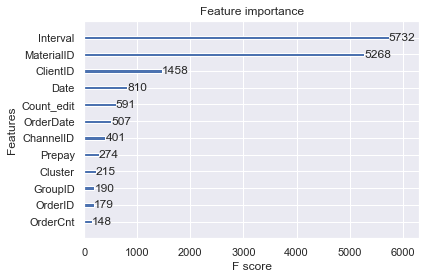

In [13]:
#Выделяем наиболее важные признаки

sns.set(font_scale = 1)
xgb.plot_importance(tree_example) #выделяет важные признаки на основе модели

In [14]:
# Итак, проделав анализ, мы можем сделать вывод, 
# что наиболее результирующими признаками.
# Теперь выполним то же самое, выбросив мешающие параметры

In [15]:
#Чтение данных из датасета только нужных нам данных

headers = ["Interval","Date","OrderDate","Cluster","CancelFlag","OrderCnt","DeliveryType", "Prepay", "Count_edit"]
train_set = pd.read_csv("/Users/alxarsnk/Desktop/AD_zach/train.csv", 
                        skiprows=range(1000000,9000000), low_memory = False, header = None, 
                        names = headers, encoding="cp1251")

In [16]:
# Так же выкидываем в датасете все Nan параметры 
# и категориальные признаки заменяем кодами

train_set = train_set.replace(' ?', np.nan).dropna()
for feature in train_set.columns:
    if train_set[feature].dtype == "object":
        train_set[feature] = pd.Categorical(train_set[feature]).codes

In [17]:
# Выведим данные о новом датасете

train_set.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23302 entries, (Interval, Date, OrderDate, ClientID, ChannelID) to (8-10., 31/12/2018, 30/12/2018, 93114842, 2)
Data columns (total 9 columns):
Interval        23302 non-null int16
Date            23302 non-null int16
OrderDate       23302 non-null int8
Cluster         23302 non-null int8
CancelFlag      23302 non-null int8
OrderCnt        23302 non-null int8
DeliveryType    23302 non-null int8
Prepay          23302 non-null int8
Count_edit      23302 non-null int8
dtypes: int16(2), int8(7)
memory usage: 500.3+ KB


In [18]:
# Снова выбрасываем из датасета целевую переменную и 
# строим матрицу признаков

cancelFlag_df = train_set.copy()
yall = cancelFlag_df.pop('CancelFlag')

xgdmat = xgb.DMatrix(cancelFlag_df, yall)

In [19]:
# Запускаем кросс-валидацию  с теми же параметрами, но
# для нового датасета

params = {
    "eta" : 0.1,
    "seed" : 0,
    "subsample" : 0.8,
    "colsample_bytree" : 0.8,
    "max_depth" : 3,
    "min_child_weight": 1
}

cv_xgb = xgb.cv(params = params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5, early_stopping_rounds = 10)
cv_xgb.tail(5)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
2089,0.022640,0.000978,0.040695,0.006376
2090,0.022616,0.000979,0.040673,0.006377
2091,0.022609,0.000984,0.040670,0.006375
2092,0.022585,0.000991,0.040659,0.006374
2093,0.022548,0.000992,0.040602,0.006389


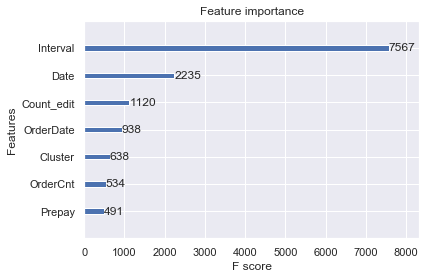

In [20]:
# Обучаем модель и строим график наиболее значимых признаков, чтобы убедиться
# что отбросив лишние параметры, все ОК

tree = xgb.train(params, xgdmat, num_boost_round = 2093)
sns.set(font_scale = 1)
xgb.plot_importance(tree)

In [21]:
# Выбираем тестовый датасет, в который входят последние 300 тысяч строк
# Сохраняем колонку с целевой переменной и выбрасываем ее из датасета

test_set = pd.read_csv("/Users/alxarsnk/Desktop/AD_zach/train.csv", skiprows=range(0,8800000), low_memory = False, header = None, names = headers, encoding="cp1251")
answers = test_set["CancelFlag"].values
test_set.pop("CancelFlag")

14-16.  26/12/2018  25/12/2018  91018908  2    0
                                          2    0
                                          2    0
                                          2    0
                                          2    0
                                              ..
8-10.   31/12/2018  30/12/2018  93114842  2    0
                                          2    0
                                          2    0
                                          2    0
                                          2    0
Name: CancelFlag, Length: 223185, dtype: int64

In [22]:
# Удаляем в тестовом датасете все Nan параметры

test_set = test_set.replace(' ?', np.nan).dropna()
for feature in test_set.columns:
    if test_set[feature].dtype == "object":
        test_set[feature] = pd.Categorical(test_set[feature]).codes


In [23]:
# На данном этапе происходит мы берем данные для обучения 
# и создаем модель, которая будет предсказывать наш CancelFlag
# Берем первые четыре признака для обучения. По ним далее и будем предсказывать


from sklearn.linear_model import LogisticRegression
from sklearn.datasets.samples_generator import make_blobs

x = train_set[["Interval","Date", "Count_edit","OrderDate"]].values
y = train_set["CancelFlag"].values
for el in y:
    if el == 2: 
        el = 1


logic_model = LogisticRegression()
logic_model.fit(x, y)

#Берем тестовые данные и просим модель предсказать нам CancelFlag

Xtest = test_set[["Interval","Date", "Count_edit","OrderDate"]].values
Ytest_logic = logic_model.predict(Xtest)


#Считаем количество занчение совпавших в реальном столбце с предсказанными

right_logic = 0
for i in range(0, Ytest_logic.size):
    if Ytest_logic[i] == answers[i]:
        right_logic = right_logic + 1
        
# Получаем процент правильности обученной модели для логистичсекой регресси
print("ANSWER For Logistic IS %.2f%%" % (right_logic/Ytest_logic.size*100))




ANSWER For Logistic IS 93.10%
ANSWER For Linear IS 0.00%
